In [12]:
import numpy as np
import keras
import matplotlib.pyplot as plt

In [13]:
import librosa
from librosa import display

#demo audio play test
path = 'LibriSpeech/dev-clean/1673/143396/1673-143396-0001.wav'
sample, sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0, duration = None)
print sampling_rate, len(sample)
duration = len(sample)/sampling_rate
print duration, "seconds"

from IPython.display import Audio
Audio(path)

16000 224800
14 seconds


In [14]:
#compute spectrogram from the audio sample

def spectrogram(samples, sample_rate = 16000.0, stride_ms=20.0,
                                window_ms=30.0, max_freq=None, eps=1e-14):

  if max_freq is None:
    max_freq = sample_rate / 2
  if max_freq > sample_rate / 2:
    raise ValueError("max_freq must not be greater than half of sample rate.")

  if stride_ms > window_ms:
    raise ValueError("Stride size must not be greater than window size.")

  stride_size = int(0.001 * sample_rate * stride_ms)
  window_size = int(0.001 * sample_rate * window_ms)

  # Extract strided windows
  truncate_size = (len(samples) - window_size) % stride_size
  samples = samples[:len(samples) - truncate_size]
  nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
  nstrides = (samples.strides[0], samples.strides[0] * stride_size)
  windows = np.lib.stride_tricks.as_strided(
      samples, shape=nshape, strides=nstrides)
  assert np.all(
      windows[:, 1] == samples[stride_size:(stride_size + window_size)])

  # Window weighting, squared Fast Fourier Transform (fft), scaling
  weighting = np.hanning(window_size)[:, None]
  fft = np.fft.rfft(windows * weighting, axis=0)
  fft = np.absolute(fft)
  fft = fft**2
  scale = np.sum(weighting**2) * sample_rate
  fft[1:-1, :] *= (2.0 / scale)
  fft[(0, -1), :] /= scale
  # Prepare fft frequency list
  freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])

  # Compute spectrogram feature
  ind = np.where(freqs <= max_freq)[0][-1] + 1
  specgram = np.log(fft[:ind, :] + eps)
    
  return np.transpose(specgram, (1, 0))

In [15]:
#compute and return the spectrogram from the path of the audio

def spectrogram_from_data(path):
    sample, sampling_rate = librosa.load(path, sr = None, mono = True, offset = 0.0, duration = None)
    
    thresh_length = 300000
    
    if len(sample) > thresh_length:
        sample = sample[:thresh_length]
    else:
        sample = np.pad(sample, (0, thresh_length - len(sample)), mode = "constant")
    
    spectro = spectrogram(sample)
    return spectro

(937, 240)
[[-22.11952143 -21.24459621 -20.57500265 ... -29.83514778 -27.73538798
  -29.44545734]
 [-23.98702177 -19.68354005 -22.19989339 ... -28.42386491 -27.15401875
  -27.33536009]
 [-21.96732337 -21.98752088 -19.17297266 ... -28.72176962 -29.94891957
  -27.76624683]
 ...
 [-32.2361913  -32.2361913  -32.2361913  ... -32.2361913  -32.2361913
  -32.2361913 ]
 [-32.2361913  -32.2361913  -32.2361913  ... -32.2361913  -32.2361913
  -32.2361913 ]
 [-32.2361913  -32.2361913  -32.2361913  ... -32.2361913  -32.2361913
  -32.2361913 ]]


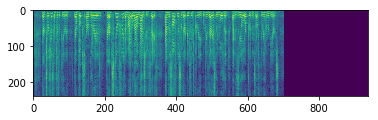

In [16]:
#demo generating spectrogram from an audio file

spectro = spectrogram_from_data(path)
print(spectro.shape)
plt.imshow(np.transpose(spectro))
print(spectro)

In [6]:
from playsound import playsound
import os
import string

#plays the audio from the audio file
def play_audio(file):
    playsound(file)

#returns transcripts of the corresponding audio file
def read_transcript(file, index):
    count = 0
    list_transcript = {}
    file_temp = open(file, 'r')
    lines = file_temp.readlines()
    for line in lines:
        temp = (line.strip()).split(" ", 1)
        list_transcript[count] = temp
        count += 1
    return list_transcript[index][1]

#converts all the '.flac' files to '.wav' files
def flac_to_wav(path):
    list_main = os.listdir(path)
    for i in range(len(list_main)):
        list_id = os.listdir(path + list_main[i])
        for j in range(len(list_id)):
            list_chap = os.listdir(path + list_main[i] + '/' + list_id[j])
            for k in list_chap:
                path_orig = path + list_main[i] + '/' + list_id[j] + '/' + k
                path_new = path_orig[:-5] + '.wav'
                if(k.endswith('.flac')):
                    os.rename(path_orig, path_new)
                    count += 1

#returns a charcter map from the englisg alphabet to number labels
def character_map():
    character_map = {}
    index_map = {}
    alphabets = string.ascii_uppercase
    index = 2
    character_map[0] = " "
    index_map[" "] = 0
    
    IN_COMMA = "' 1"
    ch, ind = IN_COMMA.split()
    character_map[ch] = int(ind)
    index_map[int(ind)] = ch
    
    for i in alphabets:
        character_map[i] = int(index)
        index_map[index] = i
        index += 1
        
    return (character_map, index_map)

#converts the given transcript of an audio file to num list from the character map 
def trans_to_num(transcript):
    char_map, index_map = character_map()
    trans_labels = [0]*400
    count = 1
    for i in transcript:
        if(i == " "):
            trans_labels[count] = 0
        #elif(int(char_map[i]) > 1): trans_labels[count] = 1
        else:
            trans_labels[count] = char_map[i]
        count += 1
    return trans_labels 

#Get data_example list of audio data and its corresponding transcript
def data_list(path = 'LibriSpeech/dev-clean/'):
    data_list = []
    list_main = os.listdir(path)
    for i in range(len(list_main)):
        list_id = os.listdir(path + list_main[i])
        for j in range(len(list_id)):
            list_chap = os.listdir(path + list_main[i] + '/' + list_id[j])
            for k in list_chap:
                path_orig = path + list_main[i] + '/' + list_id[j] + '/' + k
                trans_file = path_orig[:-9] + '.trans.txt'
                if(k.endswith('.wav')):
                    index = path_orig[-7:-4]
                    transcript = read_transcript(trans_file, int(index))
                    data = (path_orig, transcript)
                    data_list.append(data)
    return data_list
    
#generate data_ids
def data_dict_and_data_ids():
    data_dict = {}
    data_ids = []
    _list = data_list()
    total_num = len(_list)
    for i in range(total_num):
        data_dict[i] = _list[i]
        data_ids.append(i)
    return (data_dict, data_ids)

In [7]:
#demo transcript generation from audio file
trans_file = path[:-9] + '.trans.txt'
index = path[-7:-4]

transcript = read_transcript(trans_file, int(index))
print(transcript)

#obtaining transcript converted to num data from chararter map
num_trans = trans_to_num(transcript)
print(num_trans)
print(np.array(num_trans).shape)
print('Total number of training examples are',len(data_list()))
play_audio(path)

THEIR CHURCHES HAVE DISAPPEARED THEIR BOOKS ARE OBLITERATED THEIR OBSCURE FREEDOM MIGHT ALLOW A LATITUDE OF FAITH AND THE SOFTNESS OF THEIR INFANT CREED WOULD BE VARIOUSLY MOULDED BY THE ZEAL OR PRUDENCE OF THREE HUNDRED YEARS
[0, 21, 9, 6, 10, 19, 0, 4, 9, 22, 19, 4, 9, 6, 20, 0, 9, 2, 23, 6, 0, 5, 10, 20, 2, 17, 17, 6, 2, 19, 6, 5, 0, 21, 9, 6, 10, 19, 0, 3, 16, 16, 12, 20, 0, 2, 19, 6, 0, 16, 3, 13, 10, 21, 6, 19, 2, 21, 6, 5, 0, 21, 9, 6, 10, 19, 0, 16, 3, 20, 4, 22, 19, 6, 0, 7, 19, 6, 6, 5, 16, 14, 0, 14, 10, 8, 9, 21, 0, 2, 13, 13, 16, 24, 0, 2, 0, 13, 2, 21, 10, 21, 22, 5, 6, 0, 16, 7, 0, 7, 2, 10, 21, 9, 0, 2, 15, 5, 0, 21, 9, 6, 0, 20, 16, 7, 21, 15, 6, 20, 20, 0, 16, 7, 0, 21, 9, 6, 10, 19, 0, 10, 15, 7, 2, 15, 21, 0, 4, 19, 6, 6, 5, 0, 24, 16, 22, 13, 5, 0, 3, 6, 0, 23, 2, 19, 10, 16, 22, 20, 13, 26, 0, 14, 16, 22, 13, 5, 6, 5, 0, 3, 26, 0, 21, 9, 6, 0, 27, 6, 2, 13, 0, 16, 19, 0, 17, 19, 22, 5, 6, 15, 4, 6, 0, 16, 7, 0, 21, 9, 19, 6, 6, 0, 9, 22, 15, 5, 19, 6, 5, 0, 26, 6,

In [30]:
class AudioDataGenerator(keras.utils.Sequence):
   
    def __init__(self, batch_size = 128, data_dim = (937,240), shuffle = True):
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_dim = data_dim
        self.data_dict,self.data_IDs = data_dict_and_data_ids()
        self.total_train_ex = len(data_list())
        self.on_epoch_end()
        
    def __len__(self):
        
        return int(np.floor(self.total_train_ex/self.batch_size))

    def __getitem__(self, index):
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        temp_IDs = [self.data_IDs[k] for k in indexes]
        
        # Generate data
        X,y,input_length,label_length = self._data_generation(temp_IDs)
        inputs = {
            'input': X,
            'labels': y,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size])}

        return (inputs, outputs)
    
    def on_epoch_end(self):
        
        self.indexes = self.data_IDs
        if self.shuffle == True:
            np.random.shuffle(self.indexes)  
    
    def _data_generation(self, temp_IDs):
        
        X = np.empty((self.batch_size, 937, 240))
        y = np.empty((self.batch_size, 400), dtype=int)
        
        input_length = np.full(self.total_train_ex, 937, dtype = int)
        label_length = np.full(self.total_train_ex, 240, dtype = int)
        
        for i, ID in enumerate(temp_IDs):
            X[i,] = spectrogram_from_data(self.data_dict[i][0])
            y[i,] = trans_to_num(str(self.data_dict[i][1]))
        i+=1
                                 
        return (X, y, input_length, label_length)
                                 
    

('input shape', (128, 937, 240))
('output shape', (128, 400))
{'input': array([[[-32.2361913 , -32.2361913 , -32.2361913 , ..., -32.2361913 ,
         -32.2361913 , -32.2361913 ],
        [-32.2361913 , -32.2361913 , -32.2361913 , ..., -32.2361913 ,
         -32.2361913 , -32.2361913 ],
        [-32.2361913 , -32.2361913 , -32.2361913 , ..., -32.2361913 ,
         -32.2361913 , -32.2361913 ],
        ...,
        [-32.2361913 , -32.2361913 , -32.2361913 , ..., -32.2361913 ,
         -32.2361913 , -32.2361913 ],
        [-32.2361913 , -32.2361913 , -32.2361913 , ..., -32.2361913 ,
         -32.2361913 , -32.2361913 ],
        [-32.2361913 , -32.2361913 , -32.2361913 , ..., -32.2361913 ,
         -32.2361913 , -32.2361913 ]],

       [[-32.2361913 , -32.2361913 , -32.2361913 , ..., -32.2361913 ,
         -32.2361913 , -32.2361913 ],
        [-32.2361913 , -32.2361913 , -32.2361913 , ..., -32.2361913 ,
         -32.2361913 , -32.2361913 ],
        [-32.2361913 , -32.2361913 , -32.2361913 

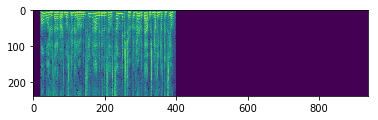

In [37]:
data_generated = AudioDataGenerator()
input, output = data_generated.__getitem__(0)

print('input shape',input['input'].shape)
print('output shape' ,input['labels'].shape)
print(input)
print(output)
plt.imshow(np.transpose(input['input'][0]))